Jiangwei Wang 19364744 &
Xiaoxi Guo 46269544

# Data 422

Data Wrangling, S2 2020

## Assignement 2

### 20% of final grade

## Due date: 2pm Tuesday 6 October 2020

The assignment must be submitted on the DATA 201 and 422 Learn page and should be **your own pair** (or group of three if we are odd) **work**. Avoid plagiarism: if you are not sure what may constitute code plagiarism, read this http://web.science.mq.edu.au/~mtaylor/ponline/index.php?id=source-code-plagiarism. Remember, when in doubt **declare your sources**.  
As a general rule, late submission are **highly** unsuggested. The pace of the course is very quick, and you don't want to be working on this too long, as you would have less time for other assignments. I suggest you to submit what you have ready by the time the assignment is due, even if it is not everything we required. For any particular problem, please contact [Thomas Li](thomas.li@canterbury.ac.nz) or [Giulio Dalla Riva](giulio.dallariva@canterbury.ac.nz) or TAs.


## Instruction

### Total: 25 marks.

For this assignment you will work with data from the web. Your goal is to scrape it or request it, wrangle it, produce some plotting, in order to demonstrate that you are able to use the functions, plotting, and markdown format we have been learning.  
You shall hand in your work as a jupyter R notebook comprehending the code, the plots and, **very important**, enough comments and explanations for us to understand what you did, how you did it, and why you did it. Remember: better comments equal to better marks.  
You can either modify this notebook or write a new one from scratch.

## Comment, explain, present your work in a clear way (1 mark)

## R part (overall 19 marks)

Do use the tidyverse syntax that's introduced in class and labs. If in doubt, refresh the lab material 1 to 4.

### Task (a): scrape it (5 marks)

Identify a website page showing information you find interesting. The information should be presented across more than one page. Select one of this pages (the rest is for later) and using `rvest` (and the suit of `tidyverse` libraries we used so far, plus any other one you may need) get the html into R.

In [1]:
# install required packages
library(tidyverse)
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr)
library(rvest) # rvest makes scraping easier
library(polite)
library(tidytext)
#install.packages("qdapRegex")
library(qdapRegex)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘qdapRegex’


The following object is masked from ‘package:dplyr’:

    explain


The following object is masked from ‘pac

I have a huge interest in photography, which gives me a decent amount of time on using and researching on photographic art and digital cameras, especially on digital single lens reflex cameras. On this part of web scraping task, we are going to scape the product information about digital cameras from a website called "https://www.photowarehouse.co.nz", which has a physic outlet as well that located in Christchurch.
Now, let's try scrape data from the first page on digital camera category.

In [2]:
# get url for just one page
url <- "https://www.photowarehouse.co.nz/shop/shop-by-product/digital-cameras/?start=0"

In [3]:
# get links for each item on that page
get_link <- function(url){
    result <- url %>% 
      read_html() %>% 
      html_nodes(".productTitle") %>%
                    html_attrs() %>%
                    map_chr("href")
    
    return(result)
}

In [4]:
# get title for each item on that page
get_title <- function(url){
    result <- url %>% 
      read_html() %>% 
      html_nodes(".productTitle") %>%
                    html_text()
    
    return(result)
}

In [5]:
# create a function to scrape the prices of each item on that page
get_price <- function(link){
  
  price_chunks <- glue("https://www.photowarehouse.co.nz{link}") %>%
   read_html() %>%
   html_nodes(".price")
  
  # we do a sanity check to see that there's something inside the lyrics!
  stopifnot(length(price_chunks) > 0)
  
  price <- price_chunks %>%
   html_text() %>%
   str_trim() %>%
   glue_collapse(sep =  "\n")
  
  return(price)
}

In [6]:
get_price_safe <- purrr::possibly(.f = get_price, # the function that we want to make safer
                                   otherwise = NA_character_) # the value we get back if .f fails

In [7]:
# create a function to scrape the specifications of each item on that page
get_spec <- function(link){
  
  spec_chunks <- glue("https://www.photowarehouse.co.nz{link}") %>%
   read_html() %>%
   html_nodes(".accordion")
  
  # we do a sanity check to see that there's something inside the lyrics!
  stopifnot(length(spec_chunks) > 0)
  
  spec <- spec_chunks %>%
   html_text() %>%
   str_trim() %>%
   glue_collapse(sep =  "\n")
  
  return(spec)
}

In [8]:
get_spec_safe <- purrr::possibly(.f = get_spec, # the function that we want to make safer
                                   otherwise = NA_character_) # the value we get back if .f fails

In [9]:
# creat a dataframe with link, title, price and specification columns of each item in each row
DSLR <- tibble(Link = url %>%
                 get_link(),
               Title = url %>%
                 get_title(),
               Price = map_chr(Link, get_price_safe),
               Spec = map_chr(Link, get_spec_safe)
               )

Now, we have a tibble that contains all the information that we need. However, they are messy, and there is a lot of information we don't need. 
Hence, what we are going to do next is to tidy it.

### Task (b): wrangle it (5 marks)


Working on the page from task (a), transform the data you collected into relational data model (that is, one or more data frames). WARNING: you will need to think and motivate how you are doing this in terms of the **data model** you are trying to build; just throwing everything in a table is not enough.

In [14]:
# create a function to extract camera brand
get_brand <- function(string){
    brand <- strsplit(string, " ")[[1]][1]
    return(brand)
}

In [15]:
# create a function to remove camera brand
rm_brand <- function(string){
    title <- strsplit(string, " ")[[1]][-1]
    return(title)
}

In [16]:
# create a function to tidy up the data frame
tidy_df <- function(data){
  data <- data %>%
    unnest_lines( # extract price
        output = lines,
        input = Price,
        to_lower = FALSE) %>% 
        mutate(Price = lines %>% 
               str_trim(), .keep = "unused") %>% # trim out white space and drop the original price column
    filter(Price %>% str_starts("[$]")) %>% # select eligible rows with $ started
    filter(!grepl("excl", Price)) %>% # extract price without gst exclusive
    mutate(Price = Price %>% str_replace("[$]", "")) %>% # remove $
    mutate(Brand = map(Title, get_brand)) %>% # extract brand from titile column
    mutate(Title = map(Title, rm_brand)) %>% # remove brand from titile column
    mutate(Pixel = Spec) # extract camera pixel from specification column

  data$Price <- as.numeric(gsub('[$,]', '', data$Price)) # turn price column into numeric data type
    
  data <- data %>%
    mutate(Format = Spec %>% # extract camera format from specification column
           str_match("Full-Frame|APS-C"), .keep = "unused") %>%
    mutate(Pixel = Pixel %>% # extract numbers only from pixel column
           qdapRegex::ex_between("Actual:", "Megapixel"))
    

  data$Pixel <- as.numeric(data$Pixel) # turn pixel column into numeric data type
  
  
  return(data)
}

In [17]:
# apply the function to tidy the dataframe
DSLR %>% tidy_df()

Link,Title,Price,Brand,Pixel,Format
<chr>,<list>,<dbl>,<list>,<dbl>,"<chr[,1]>"
/shop/shop-by-product/digital-cameras/full-frame-mirrorless/canon-eos-r6-mirrorless-24-105mm-f4-7-1-lens/,"EOS , R6 , Mirrorless, + , 24-105mm , f/4-7.1 , Lens",5489,Canon,21.40,Full-Frame
/shop/shop-by-product/digital-cameras/full-frame-mirrorless/panasonic-s5-20-60mm-f3-5-56-kit/,"S5 , 20-60mm, f3.5-56, kit",3998,Panasonic,25.28,Full-Frame
/shop/shop-by-product/digital-cameras/full-frame-mirrorless/sony-a7c-deposit/,"A7c , Deposit",300,Sony,NA,NA
/shop/shop-by-product/digital-cameras/mirrorless-system-cameras-2/fujifilm-x-a7-camera-dark-silver-15-45mm-50-230-twin-kit/,"X-A7 , Camera , ( , Dark , Silver , ) , 15-45mm, / , 50-230 , twin , kit",1100,Fujifilm,NA,APS-C
/shop/shop-by-product/digital-cameras/mirrorless-system-cameras-2/olympus-om-d-e-m10-mark-iv-mirrorless-digital-camera-with-14-150mm-lens-black/,"OM-D , E-M10 , Mark , IV , Mirrorless, Digital , Camera , with , 14-150mm , Lens , (Black)",1898,Olympus,21.80,NA
/shop/shop-by-product/digital-cameras/mirrorless-system-cameras-2/olympus-om-d-e-m10-mark-iv-mirrorless-digital-camera-with-14-150mm-lens-silver/,"OM-D , E-M10 , Mark , IV , Mirrorless, Digital , Camera , with , 14-150mm , Lens , (Silver)",1898,Olympus,21.80,NA
/shop/shop-by-product/digital-cameras/mirrorless-system-cameras-2/sony-alpha-a7c-mirrorless-28-60mm-black/,"Alpha , a7C , Mirrorless, + , 28-60mm , - , Black",4298,Sony,25.30,Full-Frame
/shop/shop-by-product/digital-cameras/mirrorless-system-cameras-2/sony-alpha-a7c-mirrorless-28-60mm-silver/,"Alpha , a7C , Mirrorless, + , 28-60mm , - , Silver",4298,Sony,25.30,Full-Frame
/shop/shop-by-product/digital-cameras/mirrorless-system-cameras-2/sony-alpha-a7c-mirrorless-body-black/,"Alpha , a7C , Mirrorless, Body , - , Black",3698,Sony,25.30,Full-Frame


Here we go, we kind of cleaned it a little bit with a lot of useful information are filtered, but still, we can do better, can't we. 
Before we go ahead, due to a big variation on the formats from a different camera that produced by different manufacture, I would like to scrape all the pages and let all the data in first, then I can clean them all at once. 
Now, let's do it!

### Task (c): automate it (5 marks)

Now it's the time to scrape everything else in the website. Turn your code for tasks (a) and (b) into a function and using `purrr` (and its `map_` functions, possibly in combination with `possibly`) apply that function to all the pages you are interested in (as we have done in lab 6); the output of the task should be a relation dataset (i.e., one or more dataframes, and if more than one, explicit their relationships).

In [18]:
# get url of digital cameras category link
url <- "https://www.photowarehouse.co.nz/shop/shop-by-product/digital-cameras/"

In [19]:
# create a list of url links of all contents
list_of_pages <- str_c(url, "?start=", seq(0, 380, by=10))

In [20]:
# create a function to get links for each item of the list
get_link <- function(url){
    result <- url %>% 
      read_html() %>% 
      html_nodes(".productTitle") %>%
                    html_attrs() %>%
                    map_chr("href")
    
    return(result)
}

In [21]:
# create a function to get title for each item of the list
get_title <- function(url){
    result <- url %>% 
      read_html() %>% 
      html_nodes(".productTitle") %>%
                    html_text()
    
    return(result)
}

In [22]:
# create a function to get price for each item of the list
get_price <- function(link){
  
  price_chunks <- glue("https://www.photowarehouse.co.nz{link}") %>%
   read_html() %>%
   html_nodes(".price")
  
  # we do a sanity check to see that there's something inside the lyrics!
  stopifnot(length(price_chunks) > 0)
  
  price <- price_chunks %>%
   html_text() %>%
   str_trim() %>%
   glue_collapse(sep =  "\n")
  
  return(price)
}

In [23]:
get_price_safe <- purrr::possibly(.f = get_price, # the function that we want to make safer
                                   otherwise = NA_character_) # the value we get back if .f fails

In [24]:
# create a function to get specification for each item of the list
get_spec <- function(link){
  
  spec_chunks <- glue("https://www.photowarehouse.co.nz{link}") %>%
   read_html() %>%
   html_nodes(".accordion")
  
  # we do a sanity check to see that there's something inside the lyrics!
  stopifnot(length(spec_chunks) > 0)
  
  spec <- spec_chunks %>%
   html_text() %>%
   str_trim() %>%
   glue_collapse(sep =  "\n")
  
  return(spec)
}

In [25]:
get_spec_safe <- purrr::possibly(.f = get_spec, # the function that we want to make safer
                                   otherwise = NA_character_) # the value we get back if .f fails

In [26]:
# creat a dataframe with link, title, price and specification columns of each item in each row
DSLR <- tibble(Link = list_of_pages %>% 
                 map(get_link) %>% 
                 unlist(),
               Title = list_of_pages %>%
                 map(get_title) %>%
                 unlist(),
               Price = map_chr(Link, get_price_safe),
               Spec = map_chr(Link, get_spec_safe)
               )

In [27]:
# create a function to get description for each item of the list if there isn't a specification available
get_desc <- function(link){
  
  desc_chunks <- glue("https://www.photowarehouse.co.nz{link}") %>%
   read_html() %>%
   html_nodes(xpath = "//div[@class='six columns']")
  
  # we do a sanity check to see that there's something inside the lyrics!
  stopifnot(length(desc_chunks) > 0)
  
  desc <- desc_chunks %>%
   html_text() %>%
   str_trim() %>%
   glue_collapse(sep =  "\n")
  
  return(desc)
}

In [28]:
get_desc_safe <- purrr::possibly(.f = get_desc, # the function that we want to make safer
                                   otherwise = NA_character_) # the value we get back if .f fails

In [29]:
# apply the function to get description if there isn't a legitimate specification 
DSLR1 <- DSLR %>%
  mutate(Spec = ifelse(!grepl("Specifications", Spec), 
                          map_chr(Link, get_desc_safe), 
                          Spec))

In [30]:
# create a function to extract camera model from title column
get_model <- function(title){
    model <- ifelse(grepl("[0-9]", title[2]) | grepl("Leica", str_to_title(title[1])) 
                    | grepl("fp", title[2]) | grepl("GR", title[2]), 
                          title[2], 
                          title[3])
    return(model)
}

In [31]:
# create a function to extract camera serie from title column
get_serie <- function(title){
    serie <- ifelse(grepl("[0-9]", title[2]) | grepl("Leica", str_to_title(title[1])) 
                    | grepl("fp", title[2]) | grepl("GR", title[2]), 
                      NA, 
                      title[2])
    return(serie)
}

In [32]:
# remove empty element from the tilte list
rm_empty <- function(title){
    title <- title[title != ""]
    return(title)
}

In [33]:
# remove brand from title column
rm_brand <- function(string){
    title <- string[-1]
    return(title)
}

In [34]:
# create a function to tidy our dataframe
tidy_df <- function(data){
  data <- data %>%
    unnest_lines( # extract price from price column
        output = lines,
        input = Price,
        to_lower = FALSE
    ) %>%
    mutate(Price = lines %>%
        str_trim(), .keep = "unused" # trim out white space and drop the original price column
          ) %>%
    filter(Price %>% 
             str_starts("[$]" # select only price columns starts with $
                       )
          ) %>%
    filter(!grepl("excl", Price # colect price rather than gst exclusive
                 )
          ) %>%
    mutate(Price = as.numeric(gsub('[$,]', '', (Price %>% # remove $ and turn into numeric data type
                                                  str_replace("[$]", ""
                                                             )
                                               )
                                  )
                             )
          ) %>%
    mutate(Brand = str_to_title(map(Title, get_brand # apply get brand function
                                   )
                               )
          ) %>%
    mutate(Title = Title %>% # slice tilte into separate strings
             strsplit(" "
                     )
          ) %>%
    mutate(Title = map(Title, rm_empty # apply remove empty strings function
                      )
          ) %>%
    mutate(Pixel = Spec %>% # get camera pixel from specification column
             str_extract("\\d+.\\d+(?= Megapixel)|\\d+(?= Megapixel)"
                                  )
          ) %>%
    mutate(Pixel = ifelse(Pixel %>% # extract pixel from title if there is none
                            is.na() & grepl("mp|MP", Title
                                           ), 
                          Title %>% 
                            str_extract("\\d+.\\d+(?=mp)|\\d+.\\d+(?=MP)|\\d+(?=mp)|\\d+(?=MP)"
                                       ), 
                          Pixel)
          ) %>%
    mutate(Pixel = ifelse(Pixel %>% # extract pixel from specification if there is none
                            is.na() & grepl("mp|MP", Spec
                                           ), 
                          Spec %>% 
                            str_extract("\\d+.\\d+(?=mp)|\\d+.\\d+(?=MP)|\\d+(?=mp)|\\d+(?=MP)"
                                       ), 
                          Pixel
                         )
          ) %>%
    mutate(Pixel = as.numeric(gsub("\"", "", (ifelse(grepl("mp|MP", Pixel # extract pixel number only and turn into numeric
                                                          ), 
                          Pixel %>% 
                            str_extract("\\d+.\\d+"
                                       ), 
                          Pixel
                                                    )
                                             )
                                  )
                             )
          ) %>%
    mutate(Speed = Spec %>% # extract speed from specification column by photos per second wiht more specific search
             str_extract("\\d+(?= fps continuous)|\\d+(?=fps continuous)"
                        )
          ) %>% 
    mutate(Speed = as.numeric(ifelse(Speed %>% is.na(), # extract speed from specification column by photos per second
                                     Spec %>% 
                                       str_extract("\\d+(?= fps)|\\d+(?=fps)"
                                                  ),
                                     Speed
                                    )
                             )
          ) %>% 
    mutate(Model = toupper(map(Title, get_model # apply model extracting function 
                              )
                          )
          ) %>%
    mutate(Serie = toupper(map(Title, get_serie # apply serie extracting function 
                              )
                          )
          ) %>%
    mutate(Serie = ifelse(grepl("EOS", Model # fix serie and model confusion
                               ), 
                          "EOS", 
                          Serie
                         )
          ) %>%
    mutate(Model = ifelse(grepl("EOS", Model
                               ), Model %>% 
                            str_replace("EOS", "" # fix serie and model confusion
                                       ),             
                          Model
                         ) 
          ) %>%
    mutate(WithLens = as.integer(ifelse(grepl("[+]", Title) | grepl("with", Title) | grepl("mm", Title), 
                                        1, # detect whether cameras are selling wiht or without a removable lens
                                        0
                                       )
                                )
          ) %>%
    mutate(Mount = ifelse(Serie == "EOS", # extract lens mount parameter from specification column
                          Spec %>% 
                            str_match("EF|RF"
                                     ), 
                          Spec %>%
                            str_extract("(?<=Lens Mount ... )\\w+ \\w+") %>%
                            str_replace("Camera", "")
                            
                         )
          ) %>%
    mutate(Zoom = toupper(Title) %>% # extract lens zoom parameter from title column
             str_extract("\\-*\\d+[-]\\-*\\d+MM|\\-*\\d+[-]\\-*\\d+|\\-*\\d+MM"
                        )
          ) %>%
    mutate(Zoom = ifelse(Zoom %>% is.na(), # extract lens zoom parameter from specification column
                         toupper(Spec) %>% 
                           str_extract("\\-*\\d+[-]\\-*\\d+MM|\\-*\\d+[-]\\-*\\d+|\\-*\\d+MM"
                                      ), 
                         Zoom)) %>% 
    mutate(Zoom = Zoom %>% # remove MM
             str_replace("MM", ""
                        )
          ) %>%
    mutate(Format = toupper(Spec) %>% #extract camera format from specification column
             str_match("FULL-FRAME|FULL FRAME|APS-C|FOUR THIRDS"
                      ) %>% 
             str_trim(), .keep = "unused" # trim out white spaces and drop the specification column
          ) %>%
    mutate(Format = ifelse(Format == "FULL FRAME", # unify camera format's format
                           "FULL-FRAME", 
                           Format
                          )
          ) %>%
    mutate(Format = ifelse(Format == "FOUR THIRDS", # unify camera format's format
                           "APS-C", 
                           Format)
          ) %>%
    
    mutate(Title = map(Title, rm_brand # aplly brand remove function
                      )
          ) %>%
    filter(!grepl("Deposit", Title # drop uneeded observations, which are not actual products
                 )
          ) %>%
    mutate(SpeedLvl = ifelse(Speed < 10, "Normal", # create an ordinal column related to camera speed
                             ifelse(10 <= Speed & Speed < 20, 
                                    "Fast", 
                                    "UltraFast"
                                   )
                            )
          ) %>%
    mutate(PixelLvl = ifelse(Pixel < 20, "Standard", # create an ordinal column related to camera pixel
                             ifelse(20 <= Pixel & Pixel < 35, 
                                    "High", 
                                    "UltraHigh"
                                   )
                            )
          ) %>%
    mutate(Model = ifelse(Brand == "Nik-D5600", # fix some website errors
                          "D5600", 
                          Model
                         )
          ) %>%
    mutate(Brand = ifelse(Brand == "Nik-D5600", # fix some website errors
                          "Nikon", 
                          Brand
                         )
          ) %>%
    mutate(Format = ifelse(grepl("D", Model) & Format %>% is.na(), # manually fill format values by camera knowledge
                          "APS-C",
                          Format
                          )
          ) %>%
    mutate(Serie = ifelse(Brand == "Ricoh-Pentax", # fix some website errors
                          "PENTAX",
                          Serie
                         )
          ) %>% 
    mutate(Brand = ifelse(Brand == "Ricoh-Pentax", # fix some website errors
                          "Ricoh",
                          Brand
                         )
          ) %>%
    mutate(Format = ifelse(Price >= 6680 & Format %>% # manually fill format values by camera knowledge
                             is.na(),
                          "MEDIUM FORMAT",
                          Format
                          )
          ) %>%
    mutate(Format = ifelse(Model == "X-T4", # fix some website errors
                          "APS-C",
                          Format
                          )
          )
     
  return(data)
}

In [244]:
# apply our tidy function and tidy it up
DSLR_tidy <- DSLR1 %>% tidy_df()

Warning message:
“Problem with `mutate()` input `Pixel`.
ℹ argument is not an atomic vector; coercing
ℹ Input `Pixel` is `ifelse(...)`.”
Warning message in stri_extract_first_regex(string, pattern, opts_regex = opts(pattern)):
“argument is not an atomic vector; coercing”
Warning message:
“Problem with `mutate()` input `Pixel`.
ℹ NAs introduced by coercion
ℹ Input `Pixel` is `as.numeric(...)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [245]:
# rearrange the columns order to make more sense
DSLR_tidy <- DSLR_tidy[c(4,  8, 7, 12, 5, 14, 6, 13, 9, 10, 11, 3)]

In [246]:
# remove duplicated rows
DSLR_tidy <- DSLR_tidy[!duplicated(DSLR_tidy),]

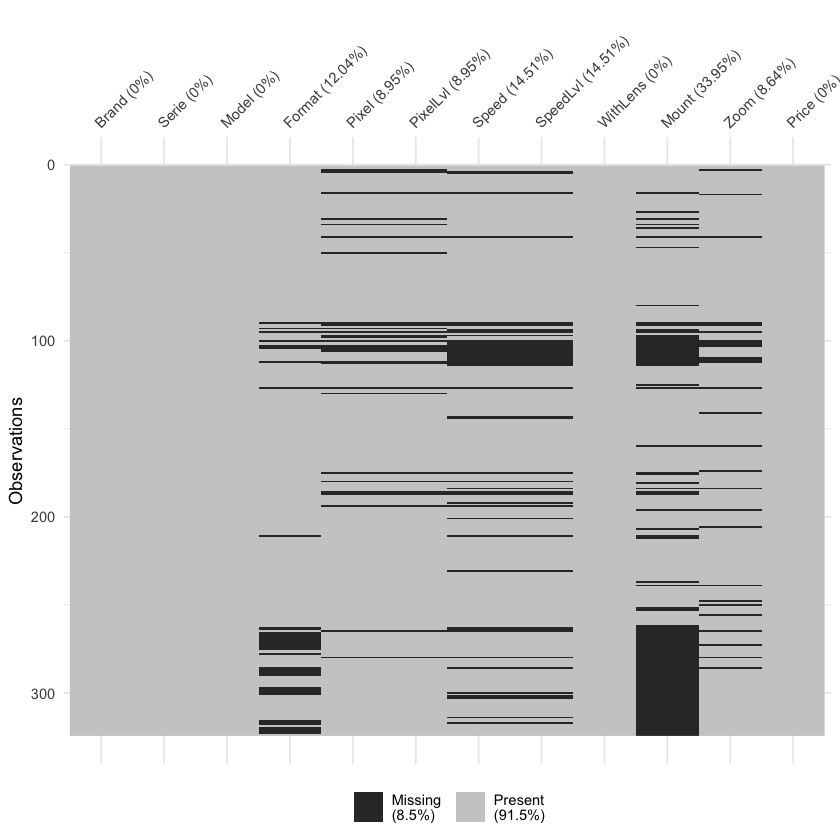

In [247]:
# visualize the missingness
library(visdat)
DSLR_tidy %>%
    vis_miss()

There are still a reasonable amount of missing data, but, only DSLR cameras have format value, and a lot of them are selling without a lens.
Anyway, let's see if we can do any better than this.

In [248]:
# count how many format values are missing
DSLR_tidy %>% filter(Format %>% is.na()) %>% count()

n
<int>
39


In [249]:
# collect all the format information we already have regarding different brand and model cameras
DSLR_Format <- DSLR_tidy[, c(1, 3, 4)] %>% 
  filter(Format != "") %>% 
  group_by(Brand, Model) %>% 
  summarise(Format1 =  unique(Format)[1])

`summarise()` regrouping output by 'Brand' (override with `.groups` argument)



In [250]:
# join them back to the dataframe with a new format column
DSLR_tidy_temp <- DSLR_tidy %>% left_join(DSLR_Format)

Joining, by = c("Brand", "Model")



In [251]:
# if the original is missing but the new format isn't, fill the original column with the corresponding new format value
# the idea is if the brand and model are both match, their format should be the same
DSLR_tidy <- DSLR_tidy_temp %>%
  mutate(Format = ifelse(Format %>% is.na() & Format1 != "", Format1, Format), .keep = "unused")

In [252]:
# count how many format values are missing now
DSLR_tidy %>% filter(Format %>% is.na()) %>% count()

n
<int>
37


Now, we fullfiled two rows, even it is only a small impact, but it is still a good try without too much effort put in it.
Let's try this method agian on pixel value.

In [253]:
# count how many rows with a missing pixel
DSLR_tidy %>% filter(Pixel %>% is.na()) %>% count()

n
<int>
29


In [254]:
# collect all the pixel information we already have regarding different brand and model cameras
DSLR_Pixel <- DSLR_tidy[, c(1, 3, 5, 6)] %>% 
  filter(Pixel != "") %>% 
  group_by(Brand, Model) %>% 
  summarise(Pixel1 =  unique(Pixel)[1], 
            PixelLvl1 = unique(PixelLvl)[1]
           )

`summarise()` regrouping output by 'Brand' (override with `.groups` argument)



In [255]:
# join them back to the dataframe with a new pixel column
DSLR_tidy_temp <- DSLR_tidy %>% left_join(DSLR_Pixel)

Joining, by = c("Brand", "Model")



In [256]:
# if the original is missing but the new pixel isn't, fill the original column with the corresponding new pixel value
# the idea is if the brand and model are both match, their pixel should be the same
DSLR_tidy <- DSLR_tidy_temp %>%
  mutate(Pixel = ifelse(Pixel %>% is.na() & Pixel1 != "", Pixel1, Pixel), .keep = "unused") %>%
  mutate(PixelLvl = ifelse(PixelLvl %>% is.na() & PixelLvl1 != "", PixelLvl1, PixelLvl), .keep = "unused")

In [257]:
# count how many pixel values are missing now
DSLR_tidy %>% filter(Pixel %>% is.na()) %>% count()

n
<int>
18


Another 11 values down. What an effort!
Let's try on the speed column with the same idea again.

In [258]:
# count how many speed values are missing
DSLR_tidy %>% filter(Speed %>% is.na()) %>% count()

n
<int>
47


In [259]:
# collect all the speed information we already have regarding different brand and model cameras
DSLR_Speed <- DSLR_tidy[, c(1, 3, 7, 8)] %>% 
  filter(Speed != "") %>% 
  group_by(Brand, Model) %>% 
  summarise(Speed1 =  unique(Speed)[1], 
            SpeedLvl1 = unique(SpeedLvl)[1]
           )

`summarise()` regrouping output by 'Brand' (override with `.groups` argument)



In [260]:
# join them back to the dataframe with a new speed column
DSLR_tidy_temp <- DSLR_tidy %>% left_join(DSLR_Speed)

Joining, by = c("Brand", "Model")



In [261]:
# if the original is missing but the new speed isn't, fill the original column with the corresponding new speed value
# the idea is if the brand and model are both match, their speed should be the same
DSLR_tidy <- DSLR_tidy_temp %>%
  mutate(Speed = ifelse(Speed %>% is.na() & Speed1 != "", Speed1, Speed), .keep = "unused") %>%
  mutate(SpeedLvl = ifelse(SpeedLvl %>% is.na() & SpeedLvl1 != "", SpeedLvl1, SpeedLvl), .keep = "unused")

In [262]:
# count how many speed values are missing now
DSLR_tidy %>% filter(Speed %>% is.na()) %>% count()

n
<int>
39


Another 8 values tackled, great!
What else could we do before we say it is tidy?

In [263]:
# assign another level "OTHER" to unformatted cameras
DSLR_tidy$Format <- replace_na(DSLR_tidy$Format, "OTHER")

In [264]:
# remove largely missing rows, which are most likely not actully cameras, or could be accesories
DSLR_tidy <- DSLR_tidy[which(rowMeans(!is.na(DSLR_tidy)) > 0.59), ]

In [266]:
# let's take a glance
DSLR_tidy %>%
 head()

Brand,Serie,Model,Format,Pixel,PixelLvl,Speed,SpeedLvl,WithLens,Mount,Zoom,Price
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>
Canon,EOS,1500D,APS-C,24.1,High,3,Normal,1,EF,18-55,1185
Canon,EOS,1500D,APS-C,24.1,High,3,Normal,1,EF,18-55,775
Canon,EOS,1DX,FULL-FRAME,NA,NA,16,Fast,0,EF,NA,12795
Canon,EOS,200D,APS-C,NA,NA,NA,NA,1,EF,18-55,1190
Canon,EOS,3000D,APS-C,18.0,Standard,NA,NA,1,EF,18-55,578
Canon,EOS,5DIV,FULL-FRAME,31.7,High,7,Normal,1,EF,24-105,5990


In [267]:
# explore the data type to confirm if they are what we expected
DSLR_tidy %>%
  class()
DSLR_tidy %>%
  typeof()
DSLR_tidy %>%
  mode()

[1] "tbl_df"     "tbl"        "data.frame"

[1] "list"

[1] "list"

In [268]:
#Show the glimpse of the dataframe 
DSLR_tidy %>% 
    glimpse()

Rows: 311
Columns: 12
$ Brand    <chr> "Canon", "Canon", "Canon", "Canon", "Canon", "Canon", "Canon…
$ Serie    <chr> "EOS", "EOS", "EOS", "EOS", "EOS", "EOS", "EOS", "EOS", "EOS…
$ Model    <chr> "1500D", "1500D", "1DX", "200D", "3000D", "5DIV", "5DIV", "5…
$ Format   <chr> "APS-C", "APS-C", "FULL-FRAME", "APS-C", "APS-C", "FULL-FRAM…
$ Pixel    <dbl> 24.10, 24.10, NA, NA, 18.00, 31.70, 31.70, 31.70, 26.20, 24.…
$ PixelLvl <chr> "High", "High", NA, NA, "Standard", "High", "High", "High", …
$ Speed    <dbl> 3, 3, 16, NA, NA, 7, 7, 7, 5, 97, 6, 6, 7, 7, 7, 10, 10, 10,…
$ SpeedLvl <chr> "Normal", "Normal", "Fast", NA, NA, "Normal", "Normal", "Nor…
$ WithLens <int> 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, …
$ Mount    <chr> "EF", "EF", "EF", "EF", "EF", "EF", "EF", "EF", "EF", "EF", …
$ Zoom     <chr> "18-55", "18-55", NA, "18-55", "18-55", "24-105", "100-32000…
$ Price    <dbl> 1185, 775, 12795, 1190, 578, 5990, 4195, 6990, 2380, 1495, 1…


We end up with a 310 rows and 12 columns dataframe, each column's data type are the same as what we expected.

In [269]:
#Load libraries for summarising the dataframe
library(skimr)
library(knitr)
#Use skim() to summarise the dataframe
DSLR_tidy %>%
 skim()


Attaching package: ‘skimr’


The following object is masked from ‘package:qdapRegex’:

    bind




── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             311       
Number of columns          12        
_______________________              
Column type frequency:               
  character                8         
  numeric                  4         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 Brand                 0         1         4    10     0       16          0
2 Serie                 0         1         2    10     0       20          0
3 Model                 0         1         1    10     0      154          0
4 Format                0         1         5    13     0        4          0
5 PixelLvl              5         0.984     4     9     0        3          0
6 SpeedLvl             26    

In [270]:
#Summarise the dataframe with kable()
DSLR_tidy %>%
    skim() %>%
    kable()



|skim_type |skim_variable | n_missing| complete_rate| character.min| character.max| character.empty| character.n_unique| character.whitespace| numeric.mean|   numeric.sd| numeric.p0| numeric.p25| numeric.p50| numeric.p75| numeric.p100|numeric.hist |
|:---------|:-------------|---------:|-------------:|-------------:|-------------:|---------------:|------------------:|--------------------:|------------:|------------:|----------:|-----------:|-----------:|-----------:|------------:|:------------|
|character |Brand         |         0|     1.0000000|             4|            10|               0|                 16|                    0|           NA|           NA|         NA|          NA|          NA|          NA|           NA|NA           |
|character |Serie         |         0|     1.0000000|             2|            10|               0|                 20|                    0|           NA|           NA|         NA|          NA|          NA|          NA|           NA|NA           

Pixel's histogram is left-skewed, the speed with a big gap, this might due to the DSLR cameras are different with mirrorless digital cameras, digital cameras' has a major advantage, which it has a faster continuous shooting speed than DSLR cameras in general. Withlens is a kind of yes or no distributed, and price's histogram is left-skewed again.

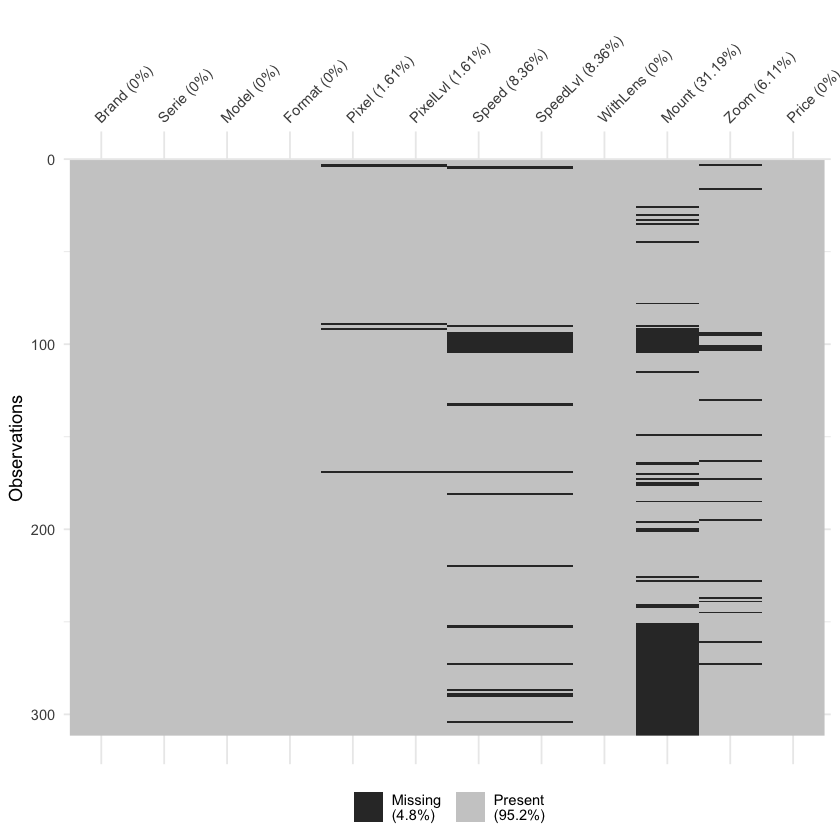

In [271]:
# display missingness again
DSLR_tidy %>%
    vis_miss()

It looks much better than before, doesn't it?

### Task (d): plot it (2 marks)

Use graphics (via `ggplot`) to represent the data you collected in a meaningful way.

In [272]:
# count number of camera by each brand
Brand_Plot <- DSLR_tidy %>% 
  group_by(Brand) %>%
  tally() %>%
  arrange(desc(n)) 

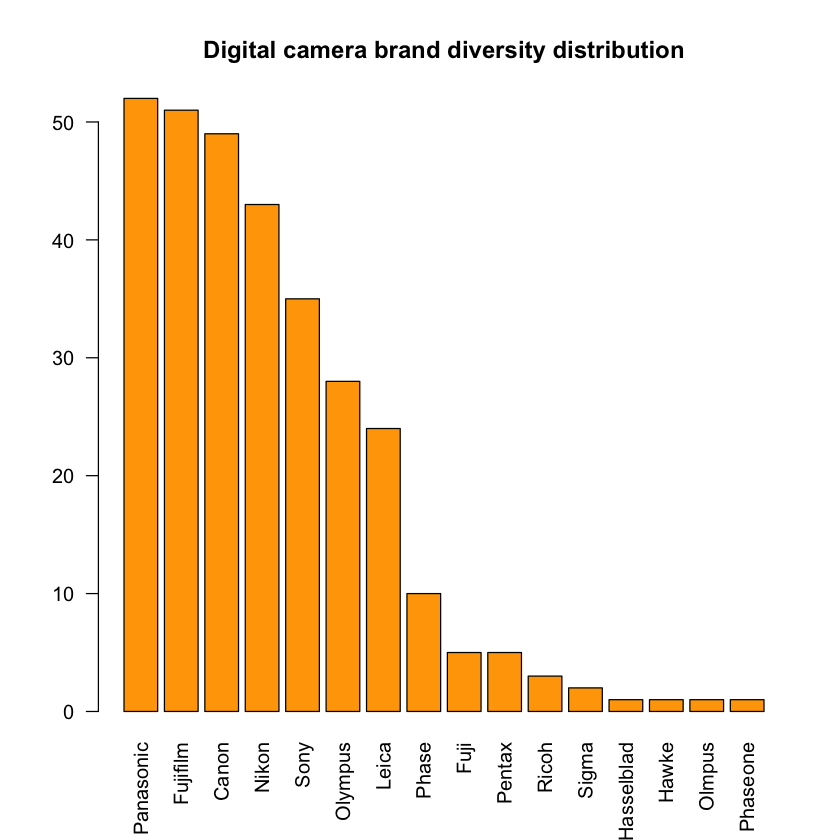

In [363]:
# plot the numbers
barplot(Brand_Plot$n, names.arg=Brand_Plot$Brand, main = "Digital camera brand diversity distribution", col="orange", las = 2)

Panasonic, Fujifilm and Canon are the 3 have the most varieties of their products.

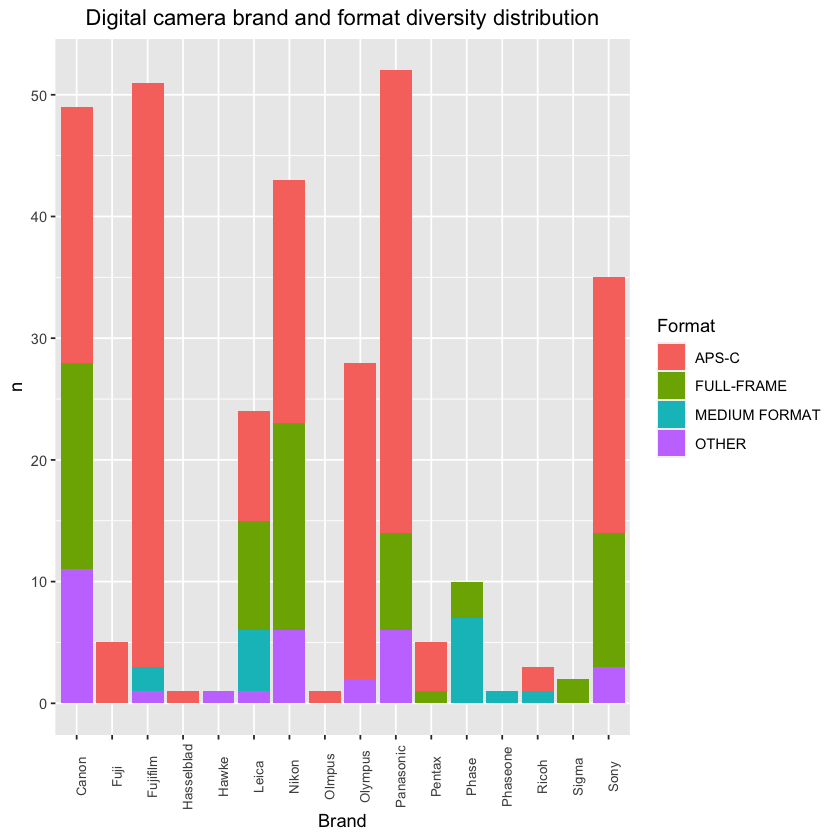

In [382]:
# count number of camera by each brand and classified by format, then plot
DSLR_tidy %>% 
  group_by(Brand, Format) %>%
  tally() %>%
  arrange(desc(n)) %>%
  ggplot(aes(fill=Format, y=n, x=Brand)) + 
    geom_bar(position="stack", stat="identity") +
    ggtitle("Digital camera brand and format diversity distribution") +
    theme(axis.text.x = element_text(size = 8, angle = 90), plot.title = element_text(hjust = 0.5))

Fujifilm and Panasonic produce most kinds of APS-C format cameras, while Canon and Nikon produce most full-frame cameras, Phase only produces full-frame and medium-frame, and it produces the most medium frame than the second place, which is Leica. Canon has most kinds of other formatted cameras as well, even its variety is ranked third, but its format range is more evenly across all the other three formats rather than medium-format, that Canon didn't come across with any of those.

In [397]:
# select the parameter columns we need to form a dataframe then reshape it to a long table
DSLR_long <- DSLR_tidy %>% 
  select(1, 5, 7, 9) %>%
  pivot_longer(cols=c(Pixel, Speed, WithLens), 
               names_to = "Parameter", 
               values_to = "Value")

`summarise()` regrouping output by 'Brand' (override with `.groups` argument)

Warning message:
“Removed 14 rows containing missing values (geom_bar).”


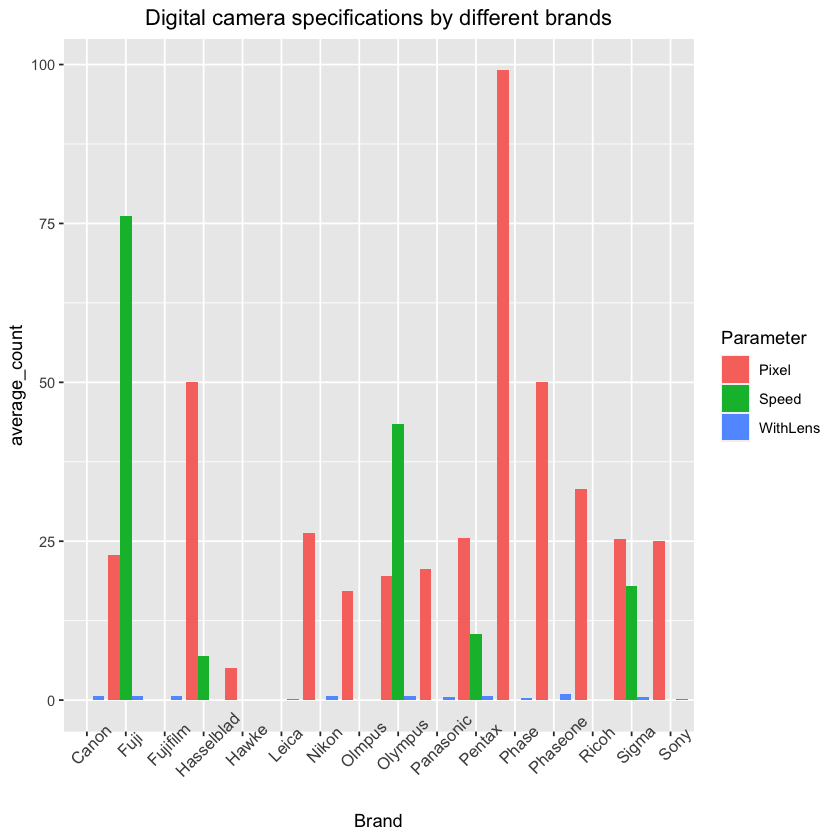

In [398]:
# plot different parameters by each brand
DSLR_long %>%
    group_by(Brand, Parameter) %>%
    summarise(average_count = mean(Value)) %>%
    ggplot(aes(fill=Parameter, y=average_count, x=Brand)) + 
    geom_bar(position="dodge", stat="identity") +
    ggtitle("Digital camera specifications by different brands") +
    theme(axis.text.x = element_text(size = 10, angle = 45), plot.title = element_text(hjust = 0.5))

The reason why we used median instead of mean to summaries each brand group is due to there are outliers, the median is a robust method that can deal with it better than mean.
Pretty clear, Phase has the highest pixel, Phaseone and Hasselblad are the second places, but almost half of what Phase can reach. Fuji has the highest speed, Olympus and Sigma are the second and third, but both only about one-fifth of the top value. Canon, Fujifilm, Nikon, Olympus, Pentax, Phaseone and Sigma are selling with a lens in some models.

### Task (e): APIs (2 marks)

Identify a web service offering data through an API. Access the API using `httr` and collect the information you care about. Convert the data into a dataframe (or more than one). Represent it graphically in a meaningful way.

In this part, we are going to scrape 7 days weather forecast data from metservice website. We applied a API key from the website, then let's try how we can use it.

In [399]:
# load required library
library(httr)
library(jsonlite)


Attaching package: ‘jsonlite’


The following object is masked from ‘package:qdapRegex’:

    validate


The following object is masked from ‘package:purrr’:

    flatten




In [406]:
# define my API key gathered through application from their website
my_API <- "C4yrjkHUlDyZWvTjfGOtMhfFVoxI3Tdj"

In [407]:
# define main url
url <- "https://forecast.metoceanapi.com/ocean/gfs/site?"

In [408]:
# define a station link regarding Christchurch station
site_time_CHC <- "times=R168/20201002T190000Z/PT1H&lon=172.632&lat=-43.525&units=nautical"

In [409]:
# glue all three components together
url_CHC <- glue(url, site_time_CHC, "&apikey=", my_API)

In [410]:
# scrape the data
raw_result_CHC <- GET(url_CHC)

In [411]:
# see how the data structured
str(raw_result_CHC)

List of 10
 $ url        : chr "https://forecast.metoceanapi.com/ocean/gfs/site?times=R168/20201002T190000Z/PT1H&lon=172.632&lat=-43.525&units="| __truncated__
 $ status_code: int 200
 $ headers    :List of 17
  ..$ content-type                : chr "application/json"
  ..$ content-length              : chr "48615"
  ..$ server                      : chr "nginx/1.10.3"
  ..$ date                        : chr "Mon, 05 Oct 2020 08:46:06 GMT"
  ..$ cache-control               : chr "max-age=600"
  ..$ expires                     : chr "Mon, 05 Oct 2020 08:56:06 GMT"
  ..$ cache-control               : chr "public"
  ..$ access-control-allow-origin : chr "*"
  ..$ x-ratelimit-limit-minute    : chr "600"
  ..$ x-ratelimit-remaining-month : chr "599937"
  ..$ x-ratelimit-remaining-minute: chr "599"
  ..$ x-ratelimit-limit-month     : chr "600000"
  ..$ x-kong-upstream-latency     : chr "0"
  ..$ x-kong-proxy-latency        : chr "4"
  ..$ via                         : chr "kong/1.5.1"
  ..$ 

In [412]:
# looking for its content
str(raw_result_CHC$content)

 raw [1:48615] 7b 0a 20 20 ...


In [413]:
# extract the content out of the JSON formatted file
content_CHC <- content(raw_result_CHC, as = "text")

No encoding supplied: defaulting to UTF-8.



In [415]:
# glance the extracted data structure
str(content_CHC)

 chr "{\n  \"dimensions\": {\n    \"time\": 168\n  }, \n  \"attributes\": {\n    \"model_cycle\": \"2020-10-05T00:00:"| __truncated__


In [416]:
# parse JSON formatted file
content_from_json_CHC <- fromJSON(content_CHC)

In [417]:
# glimpse the data
glimpse(content_from_json_CHC)

List of 3
 $ dimensions:List of 1
  ..$ time: int 168
 $ attributes:List of 2
  ..$ model_cycle   : chr "2020-10-05T00:00:00Z"
  ..$ data_extracted: chr "2020-10-05T08:41:40Z"
 $ variables :List of 18
  ..$ time                                                                                :List of 3
  .. ..$ attributes:List of 1
  .. ..$ shape     : chr "time"
  .. ..$ data      : chr [1:168] "2020-10-02T19:00:00Z" "2020-10-02T20:00:00Z" "2020-10-02T21:00:00Z" "2020-10-02T22:00:00Z" ...
  ..$ latitude                                                                            :List of 2
  .. ..$ attributes:List of 1
  .. ..$ data      : num -43.5
  ..$ longitude                                                                           :List of 2
  .. ..$ attributes:List of 1
  .. ..$ data      : num 173
  ..$ sea_surface_below_8s_period_wave_from_direction_at_variance_spectral_density_maximum:List of 3
  .. ..$ attributes:List of 2
  .. ..$ shape     : chr "time"
  .. ..$ data      : l

In [418]:
# after we parsed the content, it is able to be formed as a dataframe
data_CHC <- as.data.frame(content_from_json_CHC)

In [460]:
# define how the data consists of
str(data_CHC)

'data.frame':	168 obs. of  70 variables:
 $ time                                                                                                               : int  168 168 168 168 168 168 168 168 168 168 ...
 $ attributes.model_cycle                                                                                             : Factor w/ 1 level "2020-10-05T00:00:00Z": 1 1 1 1 1 1 1 1 1 1 ...
 $ attributes.data_extracted                                                                                          : Factor w/ 1 level "2020-10-05T08:41:40Z": 1 1 1 1 1 1 1 1 1 1 ...
 $ variables.time.units                                                                                               : Factor w/ 1 level "ISO8601 timestamps": 1 1 1 1 1 1 1 1 1 1 ...
 $ variables.time.shape                                                                                               : Factor w/ 1 level "time": 1 1 1 1 1 1 1 1 1 1 ...
 $ variables.time.data                                          

In [461]:
# select the useful data we need
data_CHC_tidy <- data_CHC %>%
    select(c(6, 18, 22, 34, 66, 70)) %>%
    rename(c(time_stamp = variables.time.data, 
             wind_speed = variables.wind_speed_at_10m_above_ground_level.data, 
             wind_direct = variables.wind_from_direction_at_10m_above_ground_level.data, 
             precipitation = variables.precipitation_flux.data, 
             air_temp = variables.air_temperature_at_2m_above_ground_level.data, 
             visibility = variables.visibility_in_air.data))

In [443]:
# conver the date time column into correct data type
data_CHC_tidy$time_stamp <- as.POSIXct(data_CHC_tidy$time_stamp, "%Y-%m-%dT%H:%M:%S", tz="UTC")

In [462]:
# glance the dataframe
data_CHC_tidy %>%
  head()

,time_stamp,wind_speed,wind_direct,precipitation,air_temp,visibility
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-10-02T19:00:00Z,6.46652,336.500,NA,11.6400,NA
2,2020-10-02T20:00:00Z,8.24838,335.700,NA,13.5800,NA
3,2020-10-02T21:00:00Z,10.03020,334.900,NA,15.5200,NA
4,2020-10-02T22:00:00Z,11.19010,330.733,NA,17.3067,NA
5,2020-10-02T23:00:00Z,12.34990,326.567,NA,19.0933,NA
6,2020-10-03T00:00:00Z,13.50970,322.400,NA,20.8800,NA


In [445]:
# reshape the dataframe to a long dataframe
data_CHC_long <- pivot_longer(data_CHC_tidy, 
                              cols=c(wind_speed, wind_direct, precipitation, air_temp, visibility), 
                              names_to = "measure", 
                              values_to = "CHC")

In [447]:
# load library to be used for plotting
library(ggplot2)

`summarise()` regrouping output by 'time_stamp' (override with `.groups` argument)

Warning message:
“Removed 103 row(s) containing missing values (geom_path).”


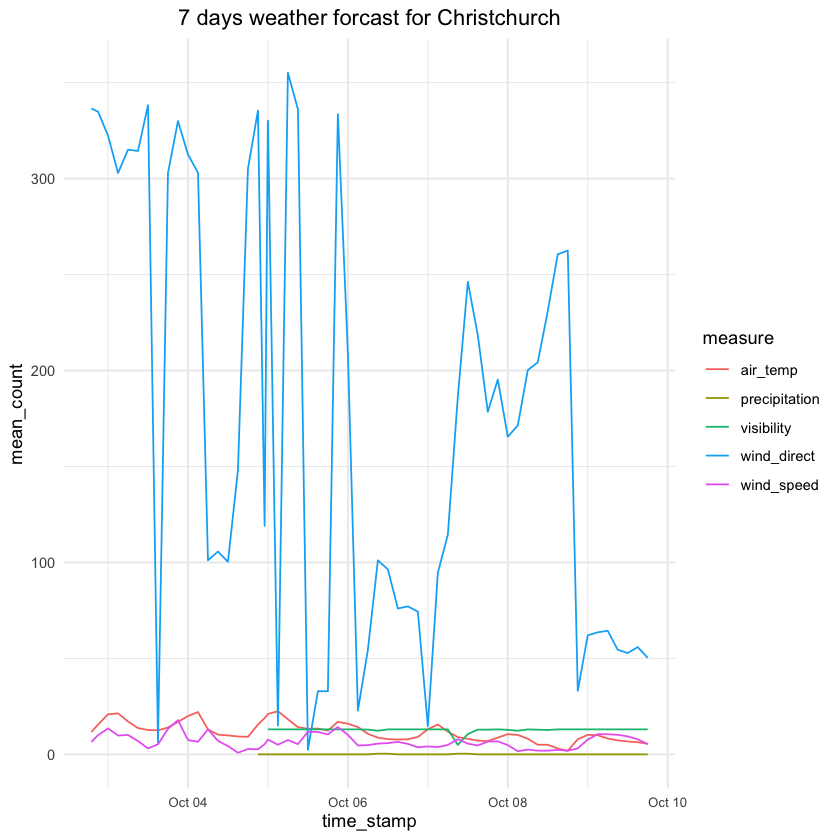

In [471]:
# plot the long dataframe
data_CHC_long %>%
    group_by(time_stamp, measure) %>%
    summarise(mean_count = mean(CHC)) %>%
    ggplot(aes(x = time_stamp, y = mean_count, colour = measure)) +
    ggtitle("7 days weather forcast for Christchurch") +
    geom_line() + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8), plot.title = element_text(hjust = 0.5))

The wind direction is steady as northerly until midday of the 7th, directing to the west and end up facing northeast on the 10th. However, due to the wind direction's value range is quite large compare to the other measurements, it is hard to see the others in details, we can plot another plot without the wind direction.

`summarise()` regrouping output by 'time_stamp' (override with `.groups` argument)

Warning message:
“Removed 103 row(s) containing missing values (geom_path).”


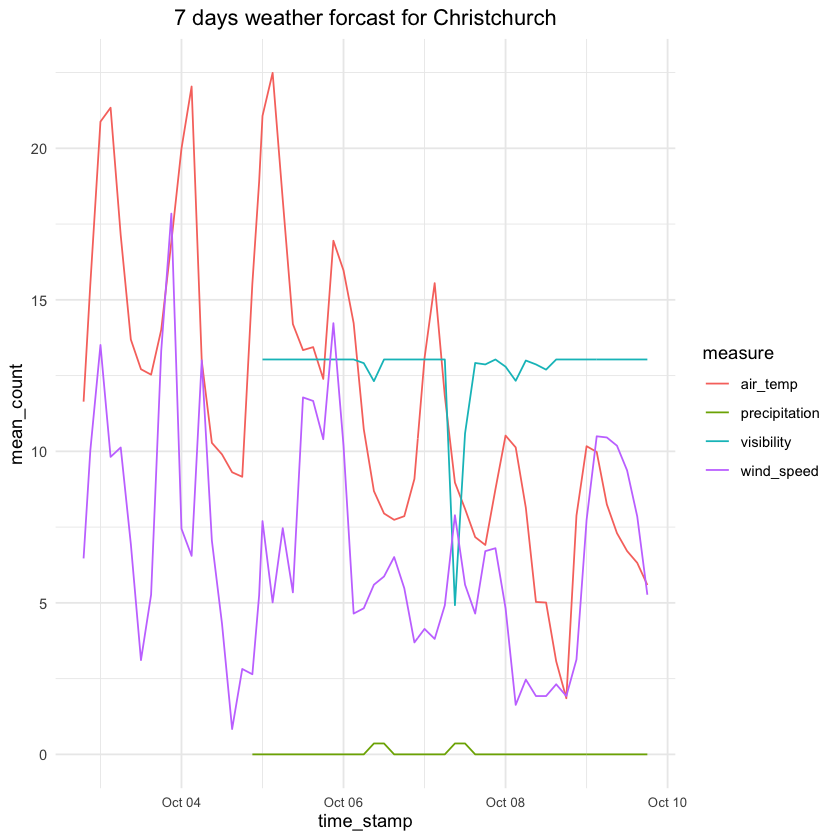

In [470]:
# plot again without the wind direction
data_CHC_long %>%
    filter(measure != "wind_direct") %>%
    group_by(time_stamp, measure) %>%
    summarise(mean_count = mean(CHC)) %>%
    ggplot(aes(x = time_stamp, y = mean_count, colour = measure)) +
    ggtitle("7 days weather forcast for Christchurch") +
    geom_line() + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8), plot.title = element_text(hjust = 0.5))

Here we are, a lot more clear to see the air temperature is fluctuating and going downwards, with only about 6 degrees on 10th in Christchurch. Wind speed is slowing down slowly, while visibility is reaching the bottom on the 7th, it is a kind of mirror-image relation with the wind speed level. Shower is forcasted on the 6th and 7th for a short period of time.

Let's try Auckland's weather forecast data.

In [452]:
# define station link
site_time_AKL <- "times=R168/20201002T190000Z/PT1H&lon=174.795&lat=-36.877&units=nautical"

In [421]:
# glue all components together
url_AKL <- glue(url, site_time_AKL, "&apikey=", my_API)

In [422]:
# scrape the data through the link
raw_result_AKL <- GET(url_AKL)

In [423]:
# find out how the data strctured
str(raw_result_AKL)

List of 10
 $ url        : chr "https://forecast.metoceanapi.com/ocean/gfs/site?times=R168/20201002T190000Z/PT1H&lon=174.795&lat=-36.877&units="| __truncated__
 $ status_code: int 200
 $ headers    :List of 17
  ..$ content-type                : chr "application/json"
  ..$ content-length              : chr "48626"
  ..$ server                      : chr "nginx/1.10.3"
  ..$ date                        : chr "Mon, 05 Oct 2020 08:50:47 GMT"
  ..$ cache-control               : chr "max-age=600"
  ..$ expires                     : chr "Mon, 05 Oct 2020 09:00:47 GMT"
  ..$ cache-control               : chr "public"
  ..$ access-control-allow-origin : chr "*"
  ..$ x-ratelimit-limit-minute    : chr "600"
  ..$ x-ratelimit-remaining-month : chr "599936"
  ..$ x-ratelimit-remaining-minute: chr "599"
  ..$ x-ratelimit-limit-month     : chr "600000"
  ..$ x-kong-upstream-latency     : chr "9499"
  ..$ x-kong-proxy-latency        : chr "28"
  ..$ via                         : chr "kong/1.5.1"
  

In [424]:
# how about the content of the data that we actually desire
str(raw_result_AKL$content)

 raw [1:48626] 7b 0a 20 20 ...


In [425]:
# extract content of the data
content_AKL <- content(raw_result_AKL, as = "text")

No encoding supplied: defaulting to UTF-8.



In [426]:
# glance the content
str(content_AKL)

 chr "{\n  \"dimensions\": {\n    \"time\": 168\n  }, \n  \"attributes\": {\n    \"model_cycle\": \"2020-10-05T00:00:"| __truncated__


In [427]:
# parse JSON formatted data
content_from_json_AKL <- fromJSON(content_AKL)

In [428]:
# glimpse the data
glimpse(content_from_json_AKL)

List of 3
 $ dimensions:List of 1
  ..$ time: int 168
 $ attributes:List of 2
  ..$ model_cycle   : chr "2020-10-05T00:00:00Z"
  ..$ data_extracted: chr "2020-10-05T08:50:47Z"
 $ variables :List of 18
  ..$ time                                                                                :List of 3
  .. ..$ attributes:List of 1
  .. ..$ shape     : chr "time"
  .. ..$ data      : chr [1:168] "2020-10-02T19:00:00Z" "2020-10-02T20:00:00Z" "2020-10-02T21:00:00Z" "2020-10-02T22:00:00Z" ...
  ..$ latitude                                                                            :List of 2
  .. ..$ attributes:List of 1
  .. ..$ data      : num -36.9
  ..$ longitude                                                                           :List of 2
  .. ..$ attributes:List of 1
  .. ..$ data      : num 175
  ..$ sea_surface_below_8s_period_wave_from_direction_at_variance_spectral_density_maximum:List of 3
  .. ..$ attributes:List of 2
  .. ..$ shape     : chr "time"
  .. ..$ data      : l

In [429]:
# now it's time to form the data into a dataframe
data_AKL <- as.data.frame(content_from_json_AKL)

In [463]:
# select the data we need and convert data time column
data_AKL_tidy <- data_AKL %>%
    select(c(6, 18, 22, 34, 66, 70)) %>%
    rename(c(time_stamp = variables.time.data, 
             wind_speed = variables.wind_speed_at_10m_above_ground_level.data, 
             wind_direct = variables.wind_from_direction_at_10m_above_ground_level.data, 
             precipitation = variables.precipitation_flux.data, 
             air_temp = variables.air_temperature_at_2m_above_ground_level.data, 
             visibility = variables.visibility_in_air.data))
data_AKL_tidy$time_stamp <- as.POSIXct(data_AKL_tidy$time_stamp, "%Y-%m-%dT%H:%M:%S", tz="UTC")
data_AKL_tidy %>%
  head()

,time_stamp,wind_speed,wind_direct,precipitation,air_temp,visibility
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-10-02 19:00:00,2.31317,330.767,NA,12.6667,NA
2,2020-10-02 20:00:00,2.29374,337.233,NA,14.0233,NA
3,2020-10-02 21:00:00,2.27430,343.700,NA,15.3800,NA
4,2020-10-02 22:00:00,2.58531,262.600,NA,16.3800,NA
5,2020-10-02 23:00:00,2.89633,181.500,NA,17.3800,NA
6,2020-10-03 00:00:00,3.20734,100.400,NA,18.3800,NA


In [464]:
# reshape it into a long dataframe
data_AKL_long <- pivot_longer(data_AKL_tidy, 
                              cols=c(wind_speed, wind_direct, precipitation, air_temp, visibility), 
                              names_to = "measure", 
                              values_to = "AKL")

`summarise()` regrouping output by 'time_stamp' (override with `.groups` argument)

Warning message:
“Removed 103 row(s) containing missing values (geom_path).”


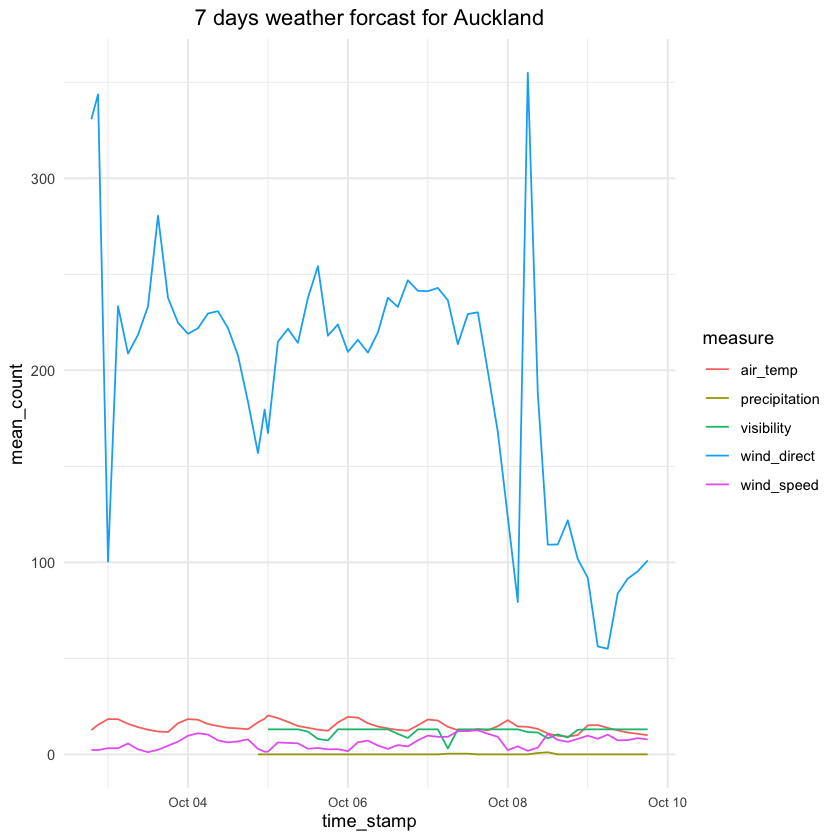

In [468]:
# group by defferent measurements and plot them
data_AKL_long %>%
  group_by(time_stamp, measure) %>%
    summarise(mean_count = mean(AKL)) %>%
    ggplot(aes(x = time_stamp, y = mean_count, colour = measure)) +
    ggtitle("7 days weather forcast for Auckland") +
    geom_line() + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8), plot.title = element_text(hjust = 0.5))

Again, wind direction is pretty clear, mainly southerly in Auckland until the end of 7th, it is changing to northerly. For the rest measurements, we can see the following plot in detail again.

`summarise()` regrouping output by 'time_stamp' (override with `.groups` argument)

Warning message:
“Removed 103 row(s) containing missing values (geom_path).”


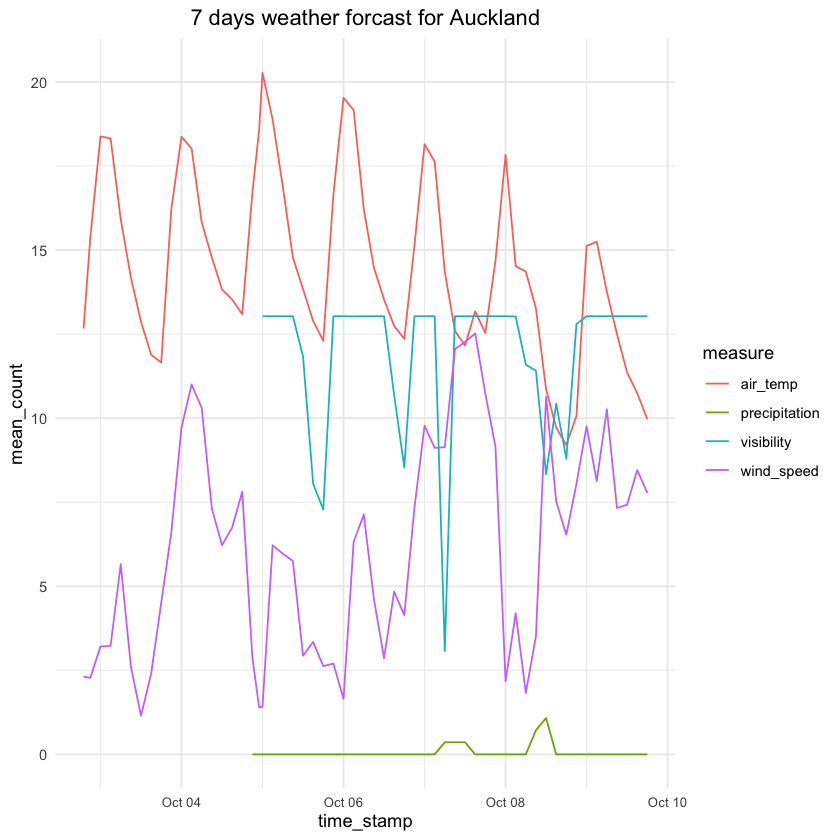

In [469]:
data_AKL_long %>%
    filter(measure != "wind_direct") %>%
    group_by(time_stamp, measure) %>%
    summarise(mean_count = mean(AKL)) %>%
    ggplot(aes(x = time_stamp, y = mean_count, colour = measure)) +
    ggtitle("7 days weather forcast for Auckland") +
    geom_line() + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8), plot.title = element_text(hjust = 0.5))

Wind speed is growing up in Auckland, temperature is dropping slightly, visibility is unclear while temperature dropped, especially in the morning of 7th. There is a couple of showers expected on 7th and 8th.

Wellington is the next.

In [430]:
# defien site link
site_time_WLG <- "times=R168/20201002T190000Z/PT1H&lon=174.773&lat=-41.273&units=nautical"

In [431]:
# glue all components together
url_WLG <- glue(url, site_time_WLG, "&apikey=", my_API)

In [432]:
# scrape the data through the link
raw_result_WLG <- GET(url_WLG)

In [472]:
# find out how the data strctured
str(raw_result_WLG)

List of 10
 $ url        : chr "https://forecast.metoceanapi.com/ocean/gfs/site?times=R168/20201002T190000Z/PT1H&lon=174.773&lat=-41.273&units="| __truncated__
 $ status_code: int 200
 $ headers    :List of 17
  ..$ content-type                : chr "application/json"
  ..$ content-length              : chr "50819"
  ..$ server                      : chr "nginx/1.10.3"
  ..$ date                        : chr "Mon, 05 Oct 2020 08:51:03 GMT"
  ..$ cache-control               : chr "max-age=600"
  ..$ expires                     : chr "Mon, 05 Oct 2020 09:01:03 GMT"
  ..$ cache-control               : chr "public"
  ..$ access-control-allow-origin : chr "*"
  ..$ x-ratelimit-limit-minute    : chr "600"
  ..$ x-ratelimit-remaining-month : chr "599935"
  ..$ x-ratelimit-remaining-minute: chr "598"
  ..$ x-ratelimit-limit-month     : chr "600000"
  ..$ x-kong-upstream-latency     : chr "7969"
  ..$ x-kong-proxy-latency        : chr "25"
  ..$ via                         : chr "kong/1.5.1"
  

In [434]:
# how about the content of the data that we actually desire
str(raw_result_WLG$content)

 raw [1:50819] 7b 0a 20 20 ...


In [435]:
# extract content of the data
content_WLG <- content(raw_result_WLG, as = "text")

No encoding supplied: defaulting to UTF-8.



In [436]:
# glance the content
str(content_WLG)

 chr "{\n  \"dimensions\": {\n    \"time\": 168\n  }, \n  \"attributes\": {\n    \"model_cycle\": \"2020-10-05T00:00:"| __truncated__


In [473]:
# parse JSON formatted data
content_from_json_WLG <- fromJSON(content_WLG)

In [438]:
# glimpse the data
glimpse(content_from_json_WLG)

List of 3
 $ dimensions:List of 1
  ..$ time: int 168
 $ attributes:List of 2
  ..$ model_cycle   : chr "2020-10-05T00:00:00Z"
  ..$ data_extracted: chr "2020-10-05T08:51:03Z"
 $ variables :List of 18
  ..$ time                                                                                :List of 3
  .. ..$ attributes:List of 1
  .. ..$ shape     : chr "time"
  .. ..$ data      : chr [1:168] "2020-10-02T19:00:00Z" "2020-10-02T20:00:00Z" "2020-10-02T21:00:00Z" "2020-10-02T22:00:00Z" ...
  ..$ latitude                                                                            :List of 2
  .. ..$ attributes:List of 1
  .. ..$ data      : num -41.3
  ..$ longitude                                                                           :List of 2
  .. ..$ attributes:List of 1
  .. ..$ data      : num 175
  ..$ sea_surface_below_8s_period_wave_from_direction_at_variance_spectral_density_maximum:List of 3
  .. ..$ attributes:List of 2
  .. ..$ shape     : chr "time"
  .. ..$ data      : n

In [439]:
# now it's time to form the data into a dataframe
data_WLG <- as.data.frame(content_from_json_WLG)

In [474]:
# select the data we need and convert data time column
data_WLG_tidy <- data_WLG %>%
    select(c(6, 18, 22, 34, 66, 70)) %>%
    rename(c(time_stamp = variables.time.data, 
             wind_speed = variables.wind_speed_at_10m_above_ground_level.data, 
             wind_direct = variables.wind_from_direction_at_10m_above_ground_level.data, 
             precipitation = variables.precipitation_flux.data, 
             air_temp = variables.air_temperature_at_2m_above_ground_level.data, 
             visibility = variables.visibility_in_air.data))
data_WLG_tidy$time_stamp <- as.POSIXct(data_WLG_tidy$time_stamp, "%Y-%m-%dT%H:%M:%S", tz="UTC")
data_WLG_tidy %>%
  head()

,time_stamp,wind_speed,wind_direct,precipitation,air_temp,visibility
,<dttm>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,2020-10-02 19:00:00,23.0410,332.200,NA,12.7733,NA
2,2020-10-02 20:00:00,24.3499,329.000,NA,13.0567,NA
3,2020-10-02 21:00:00,25.6587,325.800,NA,13.3400,NA
4,2020-10-02 22:00:00,24.7516,327.033,NA,13.5367,NA
5,2020-10-02 23:00:00,23.8445,328.267,NA,13.7333,NA
6,2020-10-03 00:00:00,22.9374,329.500,NA,13.9300,NA


In [475]:
# reshape it into a long dataframe
data_WLG_long <- pivot_longer(data_WLG_tidy, 
                              cols=c(wind_speed, wind_direct, precipitation, air_temp, visibility), 
                              names_to = "measure", 
                              values_to = "WLG")

`summarise()` regrouping output by 'time_stamp' (override with `.groups` argument)

Warning message:
“Removed 103 row(s) containing missing values (geom_path).”


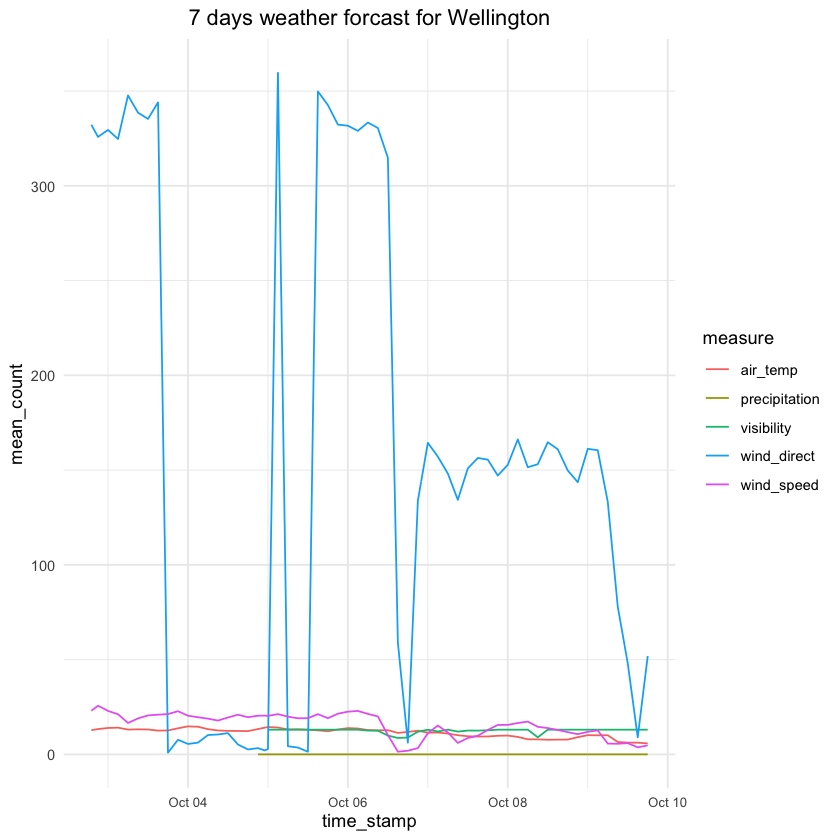

In [476]:
# group by defferent measurements and plot them
data_WLG_long %>%
  group_by(time_stamp, measure) %>%
    summarise(mean_count = mean(WLG)) %>%
    ggplot(aes(x = time_stamp, y = mean_count, colour = measure)) +
    ggtitle("7 days weather forcast for Wellington") +
    geom_line() + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8), plot.title = element_text(hjust = 0.5))

In Wellington, the wind direction is mainly northerly for a start, then directing to southerly from the beginning of 7th, and end up with northerly again on the 10th.

`summarise()` regrouping output by 'time_stamp' (override with `.groups` argument)

Warning message:
“Removed 103 row(s) containing missing values (geom_path).”


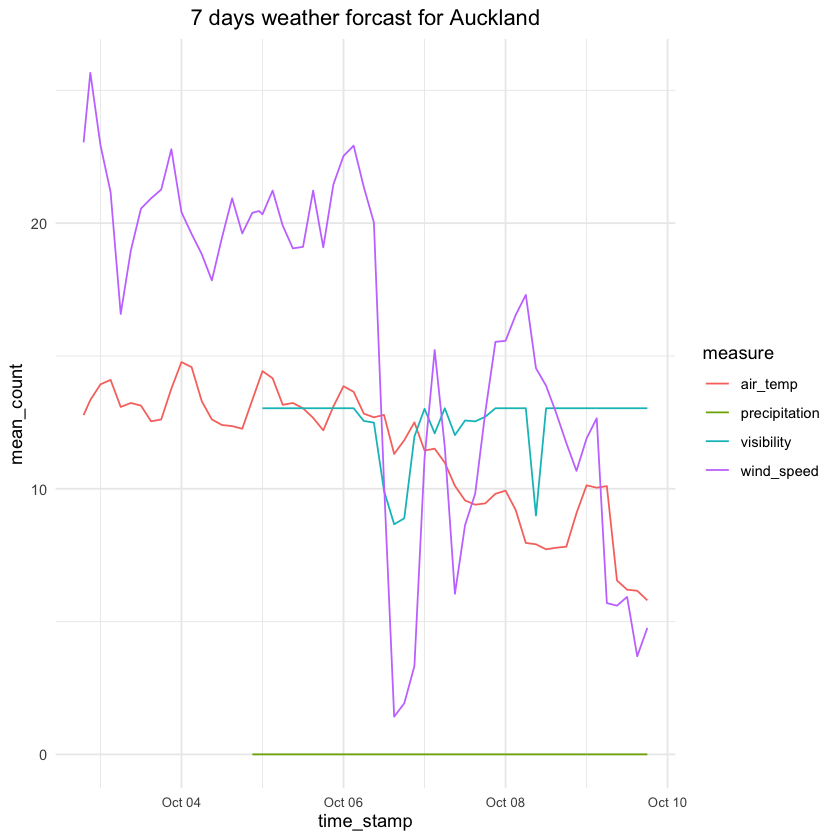

In [477]:
data_WLG_long %>%
    filter(measure != "wind_direct") %>%
    group_by(time_stamp, measure) %>%
    summarise(mean_count = mean(WLG)) %>%
    ggplot(aes(x = time_stamp, y = mean_count, colour = measure)) +
    ggtitle("7 days weather forcast for Auckland") +
    geom_line() + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8), plot.title = element_text(hjust = 0.5))

For the rest of the measurements for Wellington, wind speed is slowing down, especially on 6th, it is reaching the minimum. Air temperature is dropping to only 6 degrees on 10th. visibility is unclear on the mid day of 6th and 8th and there is no precipitation predicted.

Let's join all three stations dataframe together and do a comparison plot.

In [484]:
# join CHC and AKL together first
data_CHC_AKL_long <- data_CHC_long %>% full_join(data_AKL_long)

Joining, by = c("time_stamp", "measure")



In [485]:
# then join WLG
data_CHC_AKL_WLG <- data_CHC_AKL_long %>% full_join(data_WLG_long)

Joining, by = c("time_stamp", "measure")



In [486]:
# reshape the dataframe again to a long dataframe
data_long <- pivot_longer(data_CHC_AKL_WLG, 
                              cols=c(CHC, AKL, WLG), 
                              names_to = "city", 
                              values_to = "value")

In [487]:
# glance the long dataframe
data_long %>% 
  head()

time_stamp,measure,city,value
<dttm>,<chr>,<chr>,<dbl>
2020-10-02 19:00:00,wind_speed,CHC,6.46652
2020-10-02 19:00:00,wind_speed,AKL,2.31317
2020-10-02 19:00:00,wind_speed,WLG,23.04100
2020-10-02 19:00:00,wind_direct,CHC,336.50000
2020-10-02 19:00:00,wind_direct,AKL,330.76700
2020-10-02 19:00:00,wind_direct,WLG,332.20000


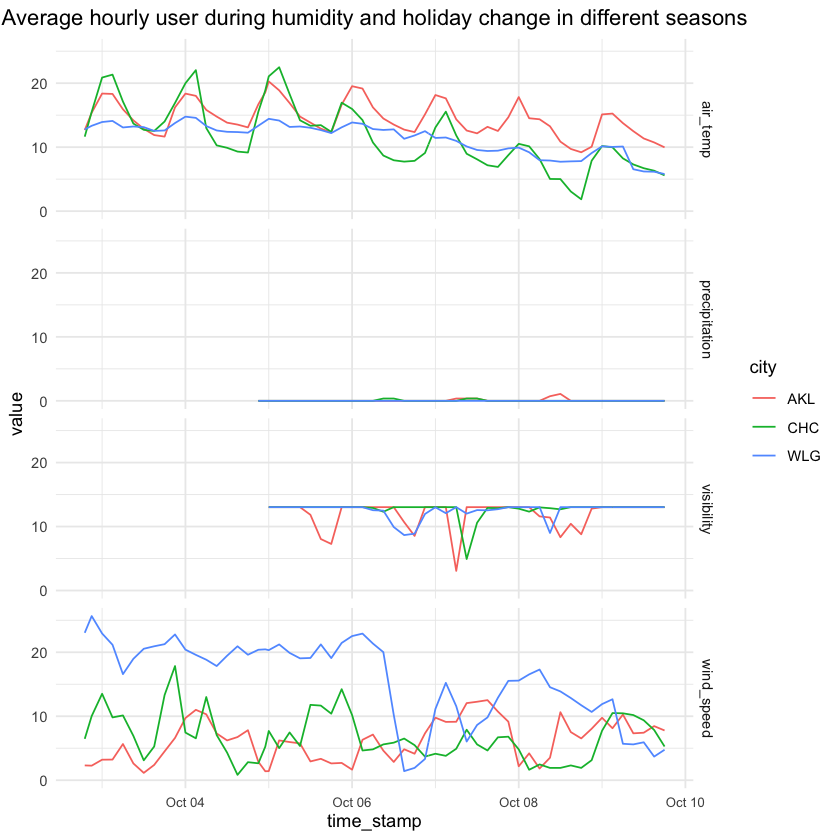

In [493]:
data_long %>%
    filter(measure != "wind_direct") %>%
    group_by(measure, city, time_stamp) %>%
    ggplot(aes(x = time_stamp, y = value, colour = city)) +
    ggtitle("Average hourly user during humidity and holiday change in different seasons") +
    geom_line(size = 0.5) + 
    theme_minimal() + 
    theme(axis.text.x = element_text(size = 8, angle = 0), plot.title = element_text(hjust = 0.5)) + 
    facet_grid(measure ~ .)

We didn't include the wind direction measurement again here, which is kind of mess our scale to be able to see other measures clearly.
All three cities' temperature is decreasing for the next 7 days, but Auckland has a higher temperature in general, and it is decreasing the slowest, on the 10th October, Auckland's temperature is going to be 4 degrees higher than the other two cities.
Auckland has the most rain or shower in general, while Wellington has nothing coming towards it.
Visibility is more or less the same while we comparing all three cities, but Auckland's visibility condition is still going to be the worst compares to all.
Wellington is the windiest town for sure, the other two cities' wind speed is going to be up and down around 7 on average, which is steady. However, Wellington's wind speed is changing dramatically on 6th afternoon and dropping to the bottom, after that, it picks up slowly and ends up with a less windy weather condition on the 10th of October.

In [497]:
# now we can convert back to a wide table and plot each of the measurements individually if we wanted to
data_long %>% 
    #select(c(time_stamp, measure, city, value)) %>%
    spread(key = "measure",
          value = "value")

time_stamp,city,air_temp,precipitation,visibility,wind_direct,wind_speed
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-10-02 19:00:00,AKL,12.6667,NA,NA,330.767,2.31317
2020-10-02 19:00:00,CHC,11.6400,NA,NA,336.500,6.46652
2020-10-02 19:00:00,WLG,12.7733,NA,NA,332.200,23.04100
2020-10-02 20:00:00,AKL,14.0233,NA,NA,337.233,2.29374
2020-10-02 20:00:00,CHC,13.5800,NA,NA,335.700,8.24838
2020-10-02 20:00:00,WLG,13.0567,NA,NA,329.000,24.34990
2020-10-02 21:00:00,AKL,15.3800,NA,NA,343.700,2.27430
2020-10-02 21:00:00,CHC,15.5200,NA,NA,334.900,10.03020
2020-10-02 21:00:00,WLG,13.3400,NA,NA,325.800,25.65870
